# Testing the `spark-ts` Library

To build this module you must follow the instructions detailed [here](https://github.com/sryza/spark-timeseries). After that, add the two lines to the conf/spark-defaults.conf file that point to the sparkts-0.3.0-jar-with-dependencies.jar file, one for spark.driver.extraClassPath and another for spark.executor.extraClassPath.

Finally, when you open up pyspark, make sure the sparkts directory is a subdirectory of your working one. The example described here is the same as the one provided [here](https://github.com/sryza/spark-ts-examples), but adapted to take a small sample of a different input data.

In [1]:
## Load libraries.
from datetime import datetime

from pyspark import SparkContext, SQLContext
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, TimestampType, DoubleType, StringType

from sparkts.datetimeindex import uniform, BusinessDayFrequency
from sparkts.timeseriesrdd import time_series_rdd_from_observations

import pandas as pd 
import matplotlib.pyplot as plt

sqlContext = SQLContext(sc)
%matplotlib inline

In [2]:
## Read each line of the file into a row.
def lineToRow(line):
    (date, sku, sold) = line.split(',')
    dt = datetime.strptime(date, '%Y%m%d')
    return (dt, sku, float(sold))

## Load input file into DF.
def loadObservations(sparkContext, sqlContext, path):
    textFile = sparkContext.textFile(path)
    rowRdd = textFile.map(lineToRow)
    schema = StructType([
        StructField('timestamp', TimestampType(), nullable=True),
        StructField('sku', StringType(), nullable=True),
        StructField('sold', DoubleType(), nullable=True),
    ])
    return sqlContext.createDataFrame(rowRdd, schema);

In [3]:
## Read input file.
meliObs = loadObservations(sc, sqlContext, "mini_series.csv")
meliObs.collect()

[Row(timestamp=datetime.datetime(2016, 6, 23, 0, 0), sku=u'MLB-704475174', sold=3679.0),
 Row(timestamp=datetime.datetime(2016, 6, 24, 0, 0), sku=u'MLB-704475174', sold=3679.0),
 Row(timestamp=datetime.datetime(2016, 6, 28, 0, 0), sku=u'MLB-704475174', sold=3680.0),
 Row(timestamp=datetime.datetime(2016, 6, 29, 0, 0), sku=u'MLB-704475174', sold=3680.0),
 Row(timestamp=datetime.datetime(2016, 6, 30, 0, 0), sku=u'MLB-704475174', sold=3680.0),
 Row(timestamp=datetime.datetime(2016, 7, 5, 0, 0), sku=u'MLB-704475174', sold=3681.0),
 Row(timestamp=datetime.datetime(2016, 7, 6, 0, 0), sku=u'MLB-704475174', sold=3687.0),
 Row(timestamp=datetime.datetime(2016, 7, 7, 0, 0), sku=u'MLB-704475174', sold=3688.0),
 Row(timestamp=datetime.datetime(2016, 7, 12, 0, 0), sku=u'MLB-704475174', sold=3696.0),
 Row(timestamp=datetime.datetime(2016, 7, 13, 0, 0), sku=u'MLB-704475174', sold=3696.0),
 Row(timestamp=datetime.datetime(2016, 7, 18, 0, 0), sku=u'MLB-704475174', sold=3698.0),
 Row(timestamp=datetime.

In [4]:
## Create an daily DateTimeIndex over August and September 2015.
freq = BusinessDayFrequency(1, 1, sc)
dtIndex = uniform(start='2016-06-23T00:00-04:00', end='2016-07-20T00:00-04:00', freq=freq, sc=sc)
dtIndex

uniform,America/New_York,2016-06-23T00:00-04:00[America/New_York],20,businessDays 1 firstDayOfWeek 1

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e058cdc10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f9df5bd15d0>], dtype=object)

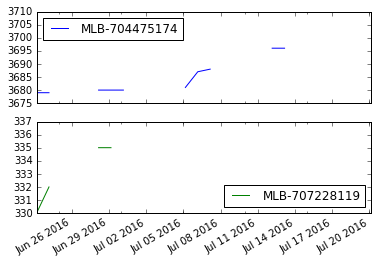

In [5]:
## Combine index and data into RDD.
meliTs = time_series_rdd_from_observations(dtIndex, meliObs, "timestamp", "sku", "sold")
meliTs.to_pandas_dataframe().plot(subplots = True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9dfc022710>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f9df2201290>], dtype=object)

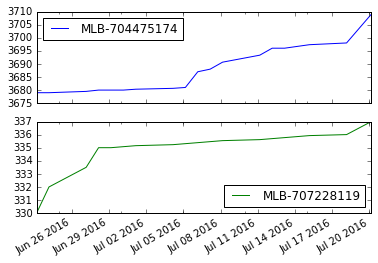

In [6]:
## Perform linear interpolation.
filled = meliTs.fill("linear")
filled.to_pandas_dataframe().plot(subplots = True)